<h1 style="color: orange;
    text-align: center;
    font-weight: bold;
    font-size: 35px;">乐高电商销售数据分析
    </h1>

<h2 style=" color: blue;
    font-style: italic;
    font-size: 32px;
">一、分析思路</h2>

<p style="   color: black;
    font-size: 16px;
">
数据集的字段主要有：商品标题，适用年龄，价格，销量，评论数量，商品详情URL，店铺名称，地理位置

由于没有订单详情，结合淘宝的页面展示信息判断，以上数据是通过爬虫获取的，而以上的地理位置信息也是店铺的位置信息</p>

<h3 style="color: purple;
    font-size: 24px;
">（一）分析目的</h3>

<p style="   color: black;
    font-size: 16px;
">通过爬虫获取数据，在业务中主要用于：竞品分析，舆情监控，对某一细分市场的专题分析

本次分析以专题分析为主，通过乐高在淘宝&天猫的销售情况挖掘乐高在国内的：供应链分布，用户搜索相关关键词，不同价位的乐高销售情况，销量TOP的乐高店铺主要销售的乐高类型</p>

<h3 style="color: purple;
    font-size: 24px;
">（二）分析方法</h3>

<h4 style="color: black;
    font-size: 21px;
">1、查看数据</h4>

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["SimHei", "Microsoft YaHei", "SimSun"]
plt.rcParams["axes.unicode_minus"] = False
%matplotlib inline

In [35]:
data=pd.read_csv(r"E:\文件下载\乐高淘宝数据.csv")

In [36]:
data.head()

,goods_name,shop_name,price,purchase_num,location
0,乐高旗舰店官网悟空小侠系列80012孙悟,乐高官方旗舰店,1299.0,['867人付款'],浙江 嘉兴
1,LEGO乐高 71043收藏版哈利波特霍格沃兹城堡玩具礼物,天猫国际进口超市,3299.0,['259人付款'],浙江 杭州
2,LEGO乐高机械组布加迪42083粉丝收藏旗舰款玩具模型礼物,天猫国际进口超市,2799.0,['441人付款'],浙江 杭州
3,乐高旗舰店官网3月新品76895超级赛车系列法拉利赛车积木玩具男孩,乐高官方旗舰店,199.0,['358人付款'],浙江 嘉兴
4,乐高旗舰店官网3月新品得宝系列10921超级英雄实验室大颗粒益智,乐高官方旗舰店,299.0,['126人付款'],浙江 嘉兴


<h4 style="color: black;
    font-size: 21px;
">2、确定分析方法</h4>

<p style="   color: black;
    font-size: 16px;
">
本次分析分为：供应链分析，商品分析，店铺分析三部分

供应链分析：通过销售乐高的淘宝店位置，分析乐高供应链在全国的分布情况，并结合店铺的月销售额数据（商品价格*购买人数），找出乐高的主要产地

商品分析：通过对商品标题的分词处理分析用户主要通过哪些关键词搜索乐高，通过月销售额的计算找出销售额TOP10的乐高类型，对乐高进行价格区间分组统计不同价位的乐高销售情况。

评论
店铺分析：找出月销售额数据TOP10的店铺，并分析TOP3店铺的主要的销售策略</p>

<h2 style=" color: blue;
    font-style: italic;
    font-size: 32px;
">二、分析过程</h2>

<h3 style="color: purple;
    font-size: 24px;
">（一）数据清洗</h3>

In [37]:
#查看重复值
data.duplicated().sum()

np.int64(993)

In [38]:
# 去除重复值
data.drop_duplicates(inplace=True)
# 删除购买人数为空的记录 :删除purchase_num中没有“人付款"的行
data = data[data['purchase_num'].str.contains('人付款')]
# 重置索引
data = data.reset_index(drop=True)
#查看数据信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3411 entries, 0 to 3410
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   goods_name    3411 non-null   object 
 1   shop_name     3411 non-null   object 
 2   price         3411 non-null   float64
 3   purchase_num  3411 non-null   object 
 4   location      3411 non-null   object 
dtypes: float64(1), object(4)
memory usage: 133.4+ KB


In [39]:
#检查缺失值
data.isnull().sum()

goods_name      0
shop_name       0
price           0
purchase_num    0
location        0
dtype: int64

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3411 entries, 0 to 3410
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   goods_name    3411 non-null   object 
 1   shop_name     3411 non-null   object 
 2   price         3411 non-null   float64
 3   purchase_num  3411 non-null   object 
 4   location      3411 non-null   object 
dtypes: float64(1), object(4)
memory usage: 133.4+ KB


In [41]:
 #转化为字符型 purchase_num处理 ：提取购买人数
data['purchase_num'] = data['purchase_num'].astype(str).str.extract(r'(\d+)').astype('int')
#location处理：提取省份信息
data['province'] = data['location'].str.split(' ').str[0]
#计算销售额
data['sales_volume'] = data['price'] * data['purchase_num']

In [42]:
data.head()

,goods_name,shop_name,price,purchase_num,location,province,sales_volume
0,乐高旗舰店官网悟空小侠系列80012孙悟,乐高官方旗舰店,1299.0,867,浙江 嘉兴,浙江,1126233.0
1,LEGO乐高 71043收藏版哈利波特霍格沃兹城堡玩具礼物,天猫国际进口超市,3299.0,259,浙江 杭州,浙江,854441.0
2,LEGO乐高机械组布加迪42083粉丝收藏旗舰款玩具模型礼物,天猫国际进口超市,2799.0,441,浙江 杭州,浙江,1234359.0
3,乐高旗舰店官网3月新品76895超级赛车系列法拉利赛车积木玩具男孩,乐高官方旗舰店,199.0,358,浙江 嘉兴,浙江,71242.0
4,乐高旗舰店官网3月新品得宝系列10921超级英雄实验室大颗粒益智,乐高官方旗舰店,299.0,126,浙江 嘉兴,浙江,37674.0


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3411 entries, 0 to 3410
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   goods_name    3411 non-null   object 
 1   shop_name     3411 non-null   object 
 2   price         3411 non-null   float64
 3   purchase_num  3411 non-null   int64  
 4   location      3411 non-null   object 
 5   province      3411 non-null   object 
 6   sales_volume  3411 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 186.7+ KB


<h3 style="color: purple;
    font-size: 24px;
">（二）供应链分析</h3>

<h4 style="color: black;
    font-size: 21px;
">1、乐高产地数量排名TOP10的地区有哪些？</h4>

In [44]:
#用value_counts()语法对lg_tb表中的province列进行统计，并按降序排列筛选前10
province_top10 = data.province.value_counts()[:10]
province_top10

province
广东    1000
上海     960
北京     662
浙江     249
江苏     144
辽宁     116
天津     113
湖北      63
山东      33
美国      29
Name: count, dtype: int64

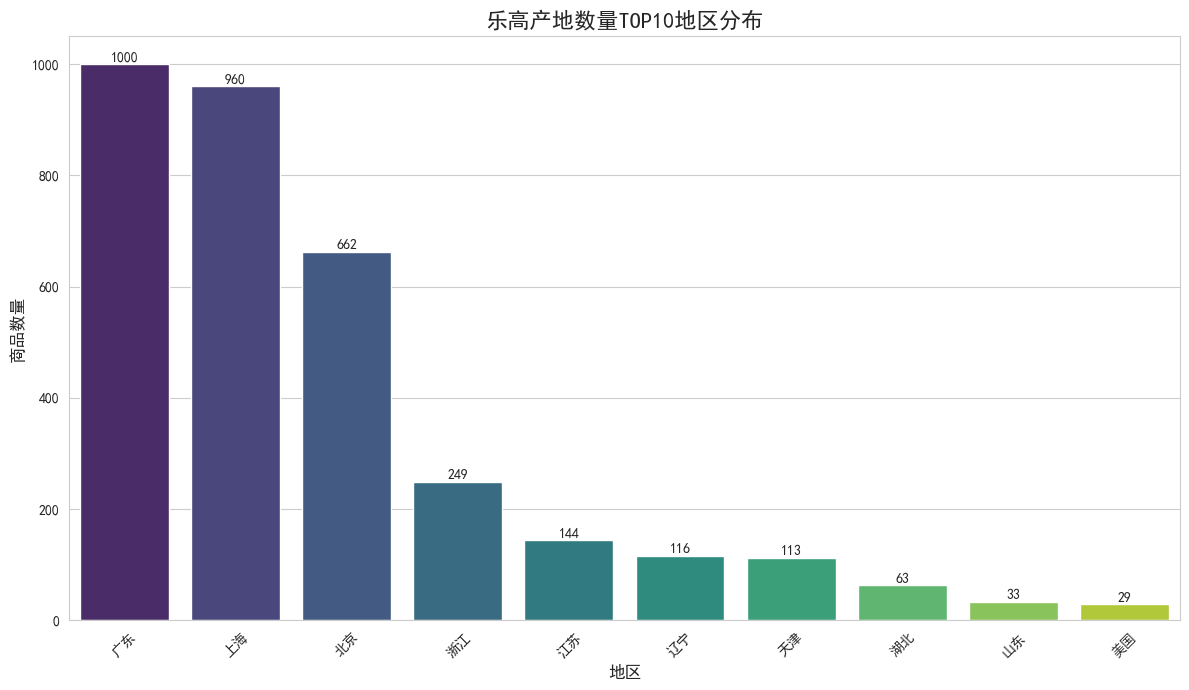

In [45]:
plt.rcParams["font.family"] = ["SimHei", "Microsoft YaHei", "SimSun"]
plt.rcParams["axes.unicode_minus"] = False
# 1. 按province列统计各地区的商品数量
province_counts = data.groupby('province').size().reset_index(name='count')

# 2. 按数量降序排序，取TOP10
province_top10 = province_counts.sort_values('count', ascending=False).head(10)

# 3. 创建画布并绘制条形图（修改这里）
plt.figure(figsize=(12, 7))
sns.barplot(
    data=province_top10,
    x='province',
    y='count',
    hue='province',  # 将x变量同时赋值给hue
    palette='viridis',
    legend=False  # 隐藏图例，因为每个条形已经有不同颜色
)

# 4. 设置图表标题和轴标签
plt.title('乐高产地数量TOP10地区分布', fontsize=16, fontweight='bold')
plt.xlabel('地区', fontsize=12)
plt.ylabel('商品数量', fontsize=12)

# 5. 添加数据标签
for i, v in enumerate(province_top10['count']):
    plt.text(i, v + 5, str(v), ha='center', fontsize=10)

# 6. 设置x轴标签旋转角度
plt.xticks(rotation=45)

# 7. 显示图表
plt.tight_layout()
plt.show()

<p style="   color: black;
    font-size: 16px;
">从淘宝店铺信息的位置来看，产地大部分都分布在广东，上海，北京地区，但考虑到有些可能并不主营乐高，只是乐高厂商的一些小代理，具体还需要结合销售额数据来验证</p>

<h4 style="color: black;
    font-size: 21px;
">2、乐高销售额排名TOP10的地区有哪些？</h4>

In [46]:
#用groupby语法对数据表按地区分组，并用sum函数统计各个地区的总销量并降序排列
province_num = data.groupby('province')['purchase_num'].sum().sort_values(ascending=False)

province_num[:10]

province
广东    172277
上海     49649
浙江     42537
北京     18003
江苏      5309
山东      3177
天津      2837
湖北      1130
福建       838
湖南       802
Name: purchase_num, dtype: int64

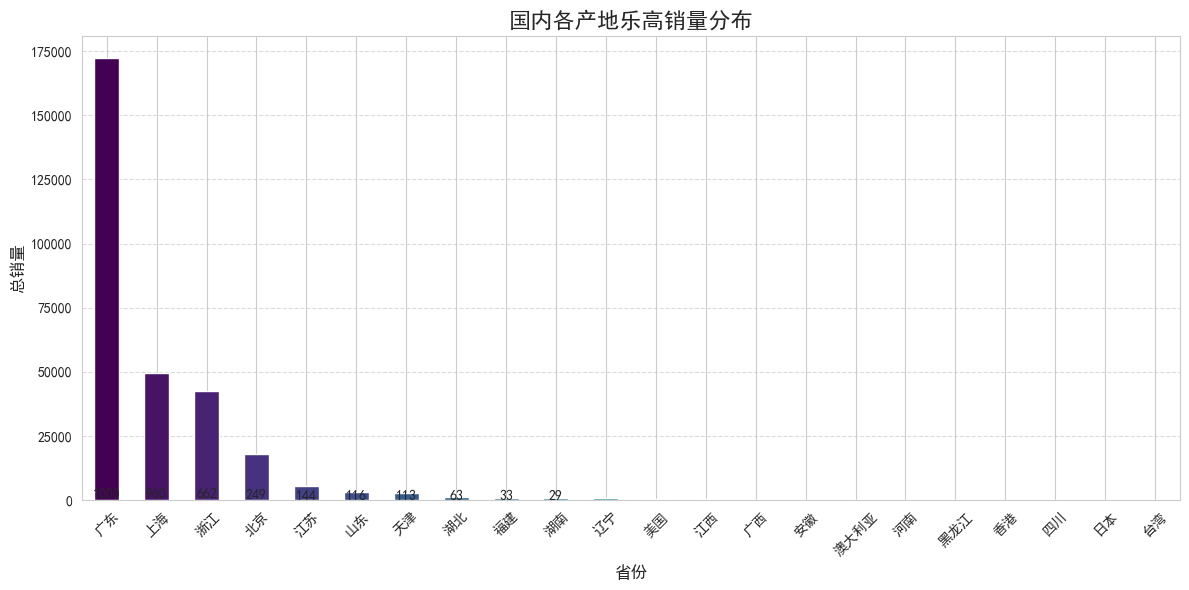

In [47]:
plt.figure(figsize=(12, 6))
province_num.plot(kind='bar', color=plt.cm.viridis(np.linspace(0, 1, len(province_num))))
plt.title('国内各产地乐高销量分布', fontsize=16)
plt.xlabel('省份', fontsize=12)
plt.ylabel('总销量', fontsize=12)
plt.xticks(rotation=45)
# 5. 添加数据标签
for i, v in enumerate(province_top10['count']):
    plt.text(i, v + 5, str(v), ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<p style="   color: black;
    font-size: 16px;
">
按销售额重新给乐高产地排序，广东和浙江分别赢得了销售额的冠军和亚军，但广东的乐高销售额是浙江的3.46倍，故我们判断乐高的主产地是广东地区</p>

<h3 style="color: purple;
    font-size: 24px;
">（三）商品分析</h3>

<h4 style="color: black;
    font-size: 21px;
">1、用户搜索乐高的关键词有哪些？</h4>

<p style="   color: black;
    font-size: 16px;
">
虽然我们没法直接拿到用户搜索“乐高”所用的关键词，但电商平台的商家一般会通过“生意参谋”“阿里指数”等关键词热度查询具找商品对应品类的热词，优化商品标题，我们可以通过对“乐高”商品的标题进行分词，找出用户搜索的高频词。</p>

In [48]:
import jieba

In [49]:
def get_cut_words(content_series):
    # 读入停用词表
    stop_words = []
    try:
        with open('stop_words.txt', 'r', encoding='utf-8') as f:
            stop_words = [line.strip() for line in f]
    except FileNotFoundError:
        print("停用词文件不存在，使用默认停用词...")
        stop_words = ['的', '了', '是', '在', '我', '有', '和', '就', '不', '人']

    # 添加自定义停用词（可选）
    my_stop_words = []
    stop_words.extend(my_stop_words)

    # 添加自定义词典（确保这些词不被拆分）
    my_words = ['乐高', '悟空小侠', '大颗粒', '小颗粒']
    for word in my_words:
        jieba.add_word(word)

    # 合并所有文本
    combined_text = content_series.str.cat(sep='。')

    # 使用 jieba 分词（精确模式）
    words = jieba.lcut(combined_text, cut_all=False)

    # 筛选有效词
    selected_words = [word for word in words if word not in stop_words and len(word) >= 2]

    return selected_words

# 使用示例
text = get_cut_words(content_series=data['goods_name'])
print(text[:20])

停用词文件不存在，使用默认停用词...
['乐高', '旗舰店', '官网', '悟空小侠', '系列', '80012', '孙悟', 'LEGO', '乐高', '71043', '收藏版', '哈利波', '特霍', '格沃兹', '城堡', '玩具', '礼物', 'LEGO', '乐高', '机械']


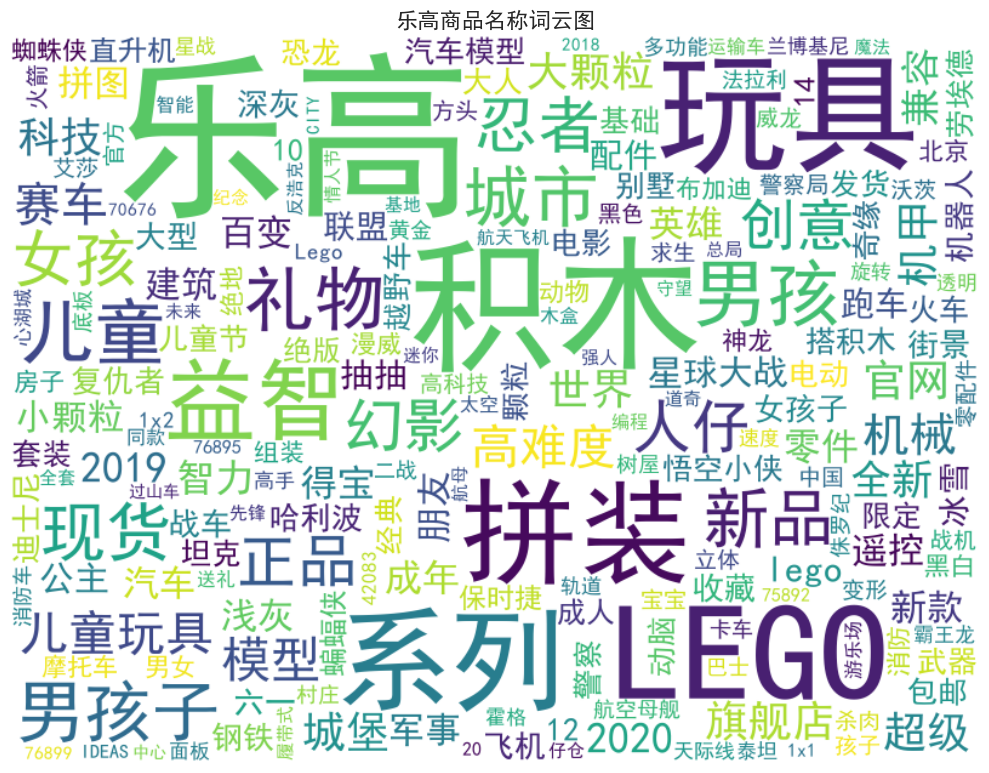

In [50]:
from wordcloud import WordCloud
from collections import Counter
plt.rcParams["font.family"] = ["SimHei", "Microsoft YaHei", "SimSun"]
plt.rcParams["axes.unicode_minus"] = False
# 计算词频
word_counts = Counter(text)

# 创建词云对象
wordcloud = WordCloud(
    font_path='simhei.ttf',  # 指定中文字体路径
    width=800,
    height=600,
    background_color='white',  # 背景颜色
    max_words=200,  # 最大词数
    max_font_size=150,  # 最大字体大小
    random_state=42  # 随机状态，保证结果可重现
)

# 生成词云
wordcloud.generate_from_frequencies(word_counts)

# 显示词云图
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 隐藏坐标轴
plt.title('乐高商品名称词云图', fontsize=16)
plt.tight_layout()
plt.show()

<p style="   color: black;
    font-size: 16px;
">乐高搜索词频排名前20的词如上，我们把这些词归下类能得到更有价值的信息：
品牌词：乐高，LEGO，旗舰店，官网（对于有影响力的品牌在标题中加入品牌词有利于获取搜索流量）
属性词：城堡，机械
功效词：礼物

综上分析我们可以得到结论：

乐高作为知名品牌有较强品牌信任度，用户比较关注购买渠道是否是官方；
在具体类型中“80012号悟空小侠系列齐天大圣乐高”和“71043号哈利波特霍格沃兹城堡乐高”最受欢迎；
乐高的主要用户是给孩子的礼物（儿童消费能力有限）</p>

<h4 style="color: black;
    font-size: 21px;
">2、销售额TOP10的乐高类型有哪些？</h4>

In [51]:
#用groupby语法对数据表按商品标题分组，并用sum函数统计各个地区的总销量并降序排列
goods_top10 = data.groupby('goods_name')['sales_volume'].sum().sort_values(ascending=False).head(10)
goods_top10

goods_name
乐高旗舰店官网悟空小侠系列80012孙悟空齐天大圣黄金机甲       6348213.0
乐高5月新品悟空小侠系列80008悟空小侠云霄战机孙悟空齐天大圣    1334825.0
兼容乐高积木拼装玩具益智坦克大人成年高难度男孩六一儿童节礼物      1287000.0
LEGO乐高机械组布加迪42083粉丝收藏旗舰款玩具模型礼物      1234359.0
乐高旗舰店官网悟空小侠系列80012孙悟                1126233.0
LEGO乐高 71043收藏版哈利波特霍格沃兹城堡玩具礼物        854441.0
乐高旗舰店官网42093雪佛兰科尔维特ZR1跑车积木玩具汽车       777067.0
兼容乐高我的世界积木男孩子益智拼装玩具儿童智力动脑六一节礼物       602000.0
乐高旗舰店官网城市组太空系列60226火星探测航天飞机积木玩具      543582.0
乐高旗舰店官网42096保时捷911RSR赛车成人送礼收藏车模      538510.0
Name: sales_volume, dtype: float64

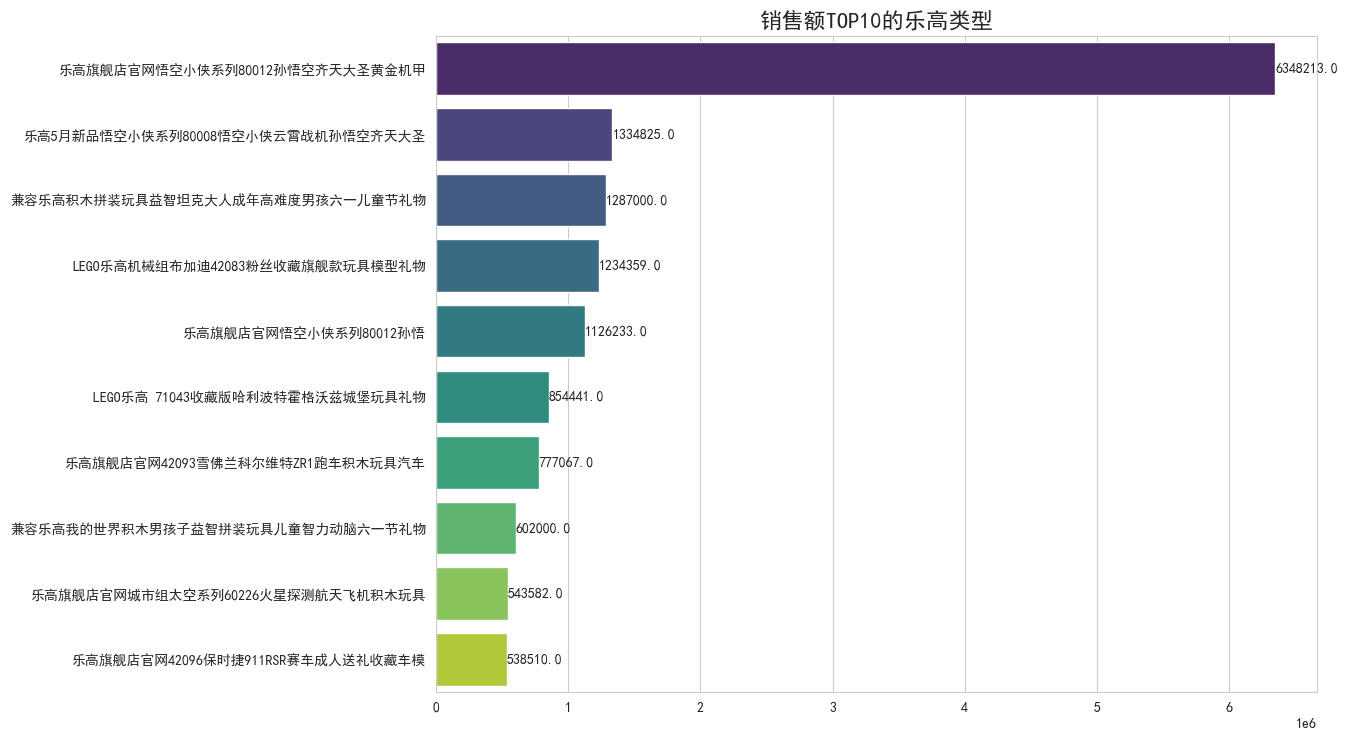

In [52]:
# 设置中文字体
plt.rcParams["font.family"] = ["SimHei", "Microsoft YaHei", "SimSun"]
plt.rcParams["axes.unicode_minus"] = False

# 假设 goods_top10 已存在
plt.figure(figsize=(13.5, 7.5))
sns.barplot(
    x=goods_top10.values,
    y=goods_top10.index,
    hue=goods_top10.index,  # 将 y 变量赋值给 hue
    palette='viridis',
    legend=False  # 隐藏图例
)
plt.title('销售额TOP10的乐高类型', fontsize=16)
plt.xlabel('')
plt.ylabel('')

# 添加数据标签
for i, v in enumerate(goods_top10.values):
    plt.text(v + 200, i, f'{v}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

乐高销售额排名前十乐高类型如上，但令人疑惑的是，在搜索关键词频率中跟80012号排名差不多的71043号乐高销售额排名竟然是第五
我们假设是由于71044号乐高价格过高导致的虽然需求量跟80012号差不多，但由于价格门槛导致销售额不如80012号，接下来查询这两个型号的乐高价格来验证下假设

In [53]:
#80012号乐高详细信息
data[data["goods_name"]=="乐高旗舰店官网悟空小侠系列80012孙悟空齐天大圣黄金机甲"]

,goods_name,shop_name,price,purchase_num,location,province,sales_volume
484,乐高旗舰店官网悟空小侠系列80012孙悟空齐天大圣黄金机甲,乐高官方旗舰店,1299.0,4664,浙江 嘉兴,浙江,6058536.0
526,乐高旗舰店官网悟空小侠系列80012孙悟空齐天大圣黄金机甲,乐高官方旗舰店,1299.0,223,浙江 嘉兴,浙江,289677.0


In [54]:
#71044号乐高详细信息
data[data["goods_name"]=="LEGO乐高 71043收藏版哈利波特霍格沃兹城堡玩具礼物"]

,goods_name,shop_name,price,purchase_num,location,province,sales_volume
1,LEGO乐高 71043收藏版哈利波特霍格沃兹城堡玩具礼物,天猫国际进口超市,3299.0,259,浙江 杭州,浙江,854441.0


71044号乐高比80012号乐高价格高出2000元，假设成立

<h4 style="color: black;
    font-size: 21px;
">3、乐高的整体销售额主要来自哪个价位区间的乐高？</h4>

In [55]:
#【统计不同价位区间的乐高销售额】
#定义价格区间
cut_bins = [0,50,100,200,300,500,1000,10000]
cut_labels = ['0~50元', '50~100元', '100~200元', '200~300元', '300~500元', '500~1000元', '1000元以上']
#统计不同价格区间的商品数量
price_cut = pd.cut(data['price'],bins=cut_bins,labels=cut_labels)
price_num = price_cut.value_counts()

data['price_cut'] = price_cut
#用group by函数按价格区间分组统计，并计算各个区间的总销售额
cut_purchase = data.groupby('price_cut', observed=True)['sales_volume'].sum()
cut_purchase

price_cut
0~50元         3276343.91
50~100元       4254628.19
100~200元      9163543.91
200~300元      4562817.64
300~500元      8885389.32
500~1000元     9250876.30
1000元以上      18742166.89
Name: sales_volume, dtype: float64

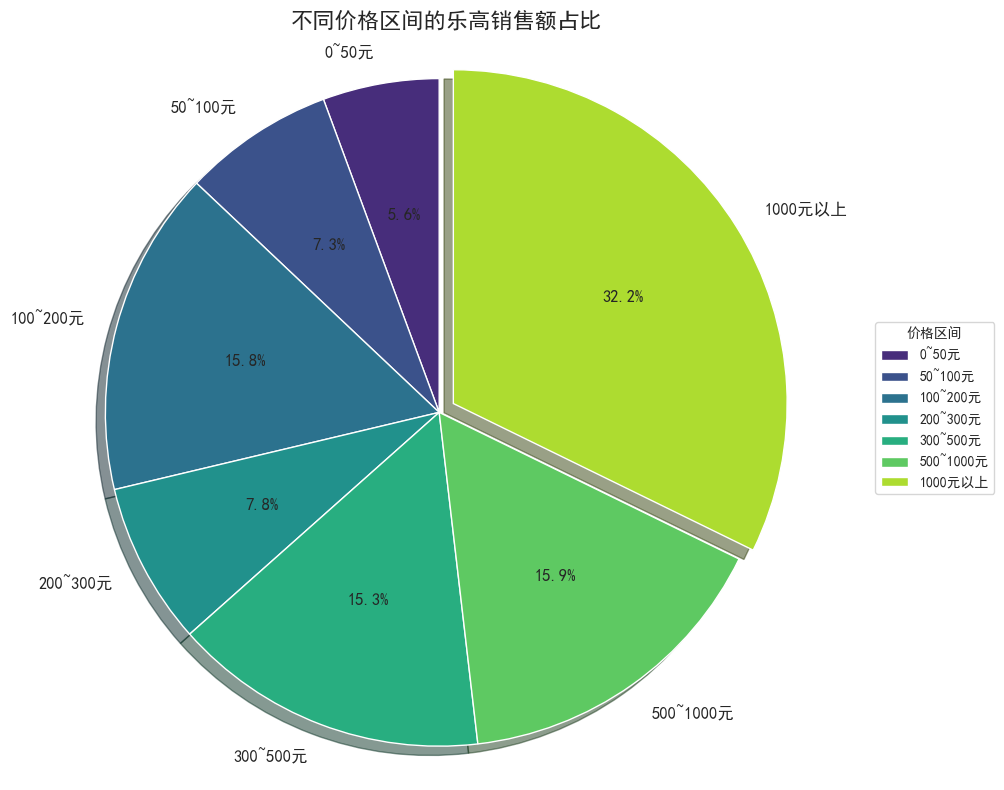

In [56]:
# 确保按价格区间顺序排序
cut_purchase = cut_purchase.loc[cut_labels]

# 创建饼图
plt.figure(figsize=(10, 8))
plt.pie(
    cut_purchase,
    labels=cut_purchase.index,
    autopct='%1.1f%%',  # 显示百分比，保留一位小数
    startangle=90,  # 从垂直方向开始绘制
    explode=[0.05 if i == cut_purchase.argmax() else 0 for i in range(len(cut_purchase))],  # 突出显示最大占比
    colors=sns.color_palette('viridis', len(cut_purchase)),  # 使用 seaborn 的颜色主题
    shadow=True,  # 添加阴影
    textprops={'fontsize': 12}  # 设置文本大小
)

# 设置标题
plt.title('不同价格区间的乐高销售额占比', fontsize=16, fontweight='bold')

# 使饼图为正圆形
plt.axis('equal')

# 添加图例（可选）
plt.legend(title="价格区间", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# 优化布局
plt.tight_layout()

# 显示图形
plt.show()

<p style="   color: black;
    font-size: 16px;
">从以上数据来看，乐高的主要销售额来源于500元以上的乐高，占总销售额的48%左右，其中1000元以上的乐高占32.2%</p>

<h3 style="color: purple;
    font-size: 24px;
">（四）店铺分析</h3>

<h4 style="color: black;
    font-size: 21px;
">1、乐高销售额TOP10的店铺有哪些？</h4>

In [57]:
#用value_counts()语法对data表中的shop_name列进行统计，并按降序排列筛选前10
shop_name_top10 = data.groupby('shop_name')['sales_volume'].sum().sort_values(ascending=False)[:10]
shop_name_top10

shop_name
乐高官方旗舰店        18258351.00
天猫国际进口超市        2326202.00
liji0904        2110141.00
天猫超市            1488300.00
童趣互娱            1308293.00
育婴益童品牌玩具折扣店      942508.00
草莓牛奶加冰           924096.00
cnnetearn        911036.00
乐高玩具专卖店          856782.00
了了包巴             629624.33
Name: sales_volume, dtype: float64

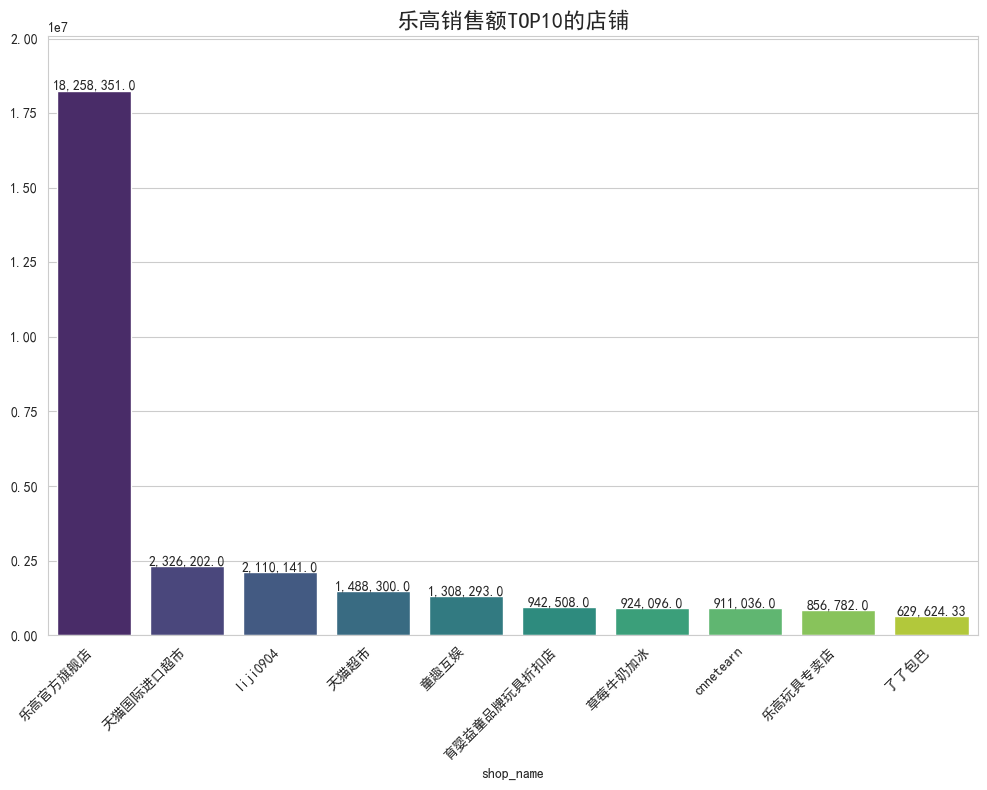

In [67]:
# 创建画布
plt.figure(figsize=(10, 8))

# 绘制条形图（修复 seaborn 警告）
sns.barplot(
    x=shop_name_top10.index,
    y=shop_name_top10.values,
    hue=shop_name_top10.index,  # 显式指定 hue
    palette='viridis',
    legend=False  # 隐藏图例
)

# 设置标题
plt.title('乐高销售额TOP10的店铺', fontsize=16, fontweight='bold')

# 设置 x 轴标签旋转
plt.xticks(rotation=45, ha='right', fontsize=10)

# 自动设置 y 轴范围
plt.ylim(0, shop_name_top10.values.max() * 1.1)

# 添加数据标签（修复索引不匹配问题）
for i, v in enumerate(shop_name_top10.values):
    plt.text(i, v + 20000, f'{v:,}', ha='center', fontsize=10)  # 逗号分隔大数值

# 优化布局
plt.tight_layout()

# 显示图形
plt.show()

<p style="   color: black;
    font-size: 16px;
">乐高销售额TOP10的店铺如上，TOP1的“乐高官方旗舰店”销售额是“TOP2的天猫进口超市”的7.8倍</p>

<h4 style="color: black;
    font-size: 21px;
">2、销售额TOP3的店铺主要的销售策略是什么？</h4>

In [59]:
#TOP1店铺销量情况(表)
goods_gf=data[data["shop_name"]=="乐高官方旗舰店"]
goods_gf_lg = goods_gf.groupby('goods_name')['sales_volume'].sum().sort_values(ascending=False)[:10]
goods_gf_lg

goods_name
乐高旗舰店官网悟空小侠系列80012孙悟空齐天大圣黄金机甲       6348213.0
乐高5月新品悟空小侠系列80008悟空小侠云霄战机孙悟空齐天大圣    1334825.0
乐高旗舰店官网悟空小侠系列80012孙悟                1126233.0
乐高旗舰店官网42093雪佛兰科尔维特ZR1跑车积木玩具汽车       777067.0
乐高旗舰店官网城市组太空系列60226火星探测航天飞机积木玩具      543582.0
乐高旗舰店官网42096保时捷911RSR赛车成人送礼收藏车模      538510.0
乐高旗舰店官网10874智能蒸汽火车遥控轨道大颗粒益智积木玩具      430965.0
乐高旗舰店官网机械组42083Bugatti积木玩具收藏         337375.0
乐高旗舰店官网Ideas系列21318树屋玩具积木成人收藏送礼      297325.0
乐高旗舰店官网得宝系列10899冰雪奇缘城堡大颗粒益智玩具积木      287913.0
Name: sales_volume, dtype: float64

<p style="   color: black;
    font-size: 16px;
">从以上产品来看，作为乐高的官方旗舰店，销售的乐高型号丰富全面，销售策略是“大而全”</p>

In [60]:
#TOP2店铺销量情况(表)
goods_gf=data[data["shop_name"]=="天猫国际进口超市"]
goods_gf_lg = goods_gf.groupby('goods_name')['sales_volume'].sum().sort_values(ascending=False)[:10]
goods_gf_lg

goods_name
LEGO乐高机械组布加迪42083粉丝收藏旗舰款玩具模型礼物    1234359.0
LEGO乐高 71043收藏版哈利波特霍格沃兹城堡玩具礼物      854441.0
直营丹麦LEGO进口乐高儿童拼装玩具                 237402.0
Name: sales_volume, dtype: float64

<p style="   color: black;
    font-size: 16px;
">从天猫进口超市销售的乐高来看，销售策略是找销量好价格高的爆款商品，少而精的“爆款策略”</p>

In [61]:
data[data["goods_name"]=="LEGO乐高机械组布加迪42083粉丝收藏旗舰款玩具模型礼物" ]

,goods_name,shop_name,price,purchase_num,location,province,sales_volume,price_cut
2,LEGO乐高机械组布加迪42083粉丝收藏旗舰款玩具模型礼物,天猫国际进口超市,2799.0,441,浙江 杭州,浙江,1234359.0,1000元以上


In [62]:
data[data["goods_name"]=="LEGO乐高 71043收藏版哈利波特霍格沃兹城堡玩具礼物" ]

,goods_name,shop_name,price,purchase_num,location,province,sales_volume,price_cut
1,LEGO乐高 71043收藏版哈利波特霍格沃兹城堡玩具礼物,天猫国际进口超市,3299.0,259,浙江 杭州,浙江,854441.0,1000元以上


In [63]:
data[data["goods_name"]=="直营丹麦LEGO进口乐高儿童拼装玩具"]

,goods_name,shop_name,price,purchase_num,location,province,sales_volume,price_cut
235,直营丹麦LEGO进口乐高儿童拼装玩具,天猫国际进口超市,1199.0,198,浙江 杭州,浙江,237402.0,1000元以上


<p style="   color: black;
    font-size: 16px;
">以上商品价格都在1000元以上，假设成立</p>

In [64]:
#TOP3店铺销量情况(表)
goods_gf=data[data["shop_name"]=="liji0904"]
goods_gf_lg = goods_gf.groupby('goods_name')['sales_volume'].sum().sort_values(ascending=False)[:10]
goods_gf_lg

goods_name
乐高迪士尼城堡71040大型积木拼装玩具男女孩儿童礼物旗舰店官网         221060.0
乐高哈利波特75954霍格沃茨城堡75948钟楼男女孩拼装积木玩具礼物      195096.0
乐高75551玩变小黄人神偷奶爸电影男女孩积木玩具六一儿童节礼物         170748.0
乐高积木拼装玩具男孩speed系列汽赛车模型75892旗舰店官网76895    116640.0
乐高得宝10875蒸汽火车大颗粒积木玩具六一儿童节礼物旗舰店官网         109372.0
乐高10269哈雷摩托车王一博同款男孩拼装积木玩具六一儿童节礼物         101753.0
乐高21320恐龙化石套装男女孩益智拼装积木玩具六一儿童节礼物           91134.0
乐高积木玩具幻影忍者70676劳埃德泰坦机甲六一儿童节礼物旗舰店          87185.0
乐高哈利波特霍格沃兹城堡71043益智积木男女孩成年高难度玩具           78844.0
乐高城市太空60229火箭装载运输中心男孩积木玩具六一儿童节礼物          77121.0
Name: sales_volume, dtype: float64

<p style="   color: black;
    font-size: 16px;
">从以上销售的产品来看liji0904店铺的策略应该跟乐高旗舰店类似，但由于没有官方的品牌势能，销售额与官方相差甚多</p>

In [65]:
liji0904=data[data["shop_name"]=="liji0904"][:20]
liji0904

,goods_name,shop_name,price,purchase_num,location,province,sales_volume,price_cut
22,乐高21320恐龙化石套装男女孩益智拼装积木玩具六一儿童节礼物,liji0904,498.0,183,上海,上海,91134.0,300~500元
25,乐高积木玩具幻影忍者70676劳埃德泰坦机甲六一儿童节礼物旗舰店,liji0904,329.0,265,上海,上海,87185.0,300~500元
64,乐高积木拼装玩具男孩speed系列汽赛车模型75892旗舰店官网76895,liji0904,108.0,1080,上海,上海,116640.0,100~200元
69,乐高幻影忍者70677封赏之地战车男孩积木玩具70678六一儿童节礼物,liji0904,719.0,84,上海,上海,60396.0,500~1000元
113,乐高女孩好朋友41381海上爱心救援船拼装积木玩具六一儿童节礼物,liji0904,715.0,23,上海,上海,16445.0,500~1000元
148,乐高得宝10875蒸汽火车大颗粒积木玩具六一儿童节礼物旗舰店官网,liji0904,739.0,148,上海,上海,109372.0,500~1000元
153,乐高悟空小侠80010牛魔王烈火机甲男女孩积木玩具六一儿童节礼物,liji0904,779.0,25,上海,上海,19475.0,500~1000元
201,乐高女孩好朋友41375心湖城豪华游乐场积木玩具六一儿童节礼物,liji0904,599.0,75,上海,上海,44925.0,500~1000元
203,乐高10268维斯塔斯风力发电机绝版男女孩益智拼装积木玩具礼物,liji0904,1358.0,7,上海,上海,9506.0,1000元以上
250,乐高幻影忍者积木70674烈焰威龙71702机甲男孩子拼装益智儿童玩具,liji0904,308.0,77,上海,上海,23716.0,300~500元


<p style="   color: black;
    font-size: 16px;
">liji0904店铺销售的乐高各个价位的都有，假设成立</p>

<h2 style=" color: blue;
    font-style: italic;
    font-size: 32px;
">三、分析结论</h2>

<p style="   color: black;
    font-size: 16px;
">综上分析我们可以得到以下结论：

供应链：乐高产品的供应链主要分布在广东地区，部分分布在浙江地区，同时在国内大部分地区都有分销商

商品分析：乐高作为知名品牌有较强品牌信任度，用户比较关注购买渠道是否是官方；在具体类型中“80012号悟空小侠系列齐天大圣乐高”和“71043号哈利波特霍格沃兹城堡乐高”最受欢迎；乐高的主要用户是给孩子的礼物（儿童消费能力有限）；乐高的主要销售额来源于500元以上的乐高，占总销售额的48%左右。

店铺分析：乐高销售额TOP1的“乐高官方旗舰店”销售额是“TOP2的天猫进口超市”的7.8倍；TOP1官方店铺的销售策略是大而全，TOP2天猫进口超市的销售策略是少而精</p>